In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', 
                   index_col='Month',
                   date_parser=dateparse,
                   dtype='float')
data.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


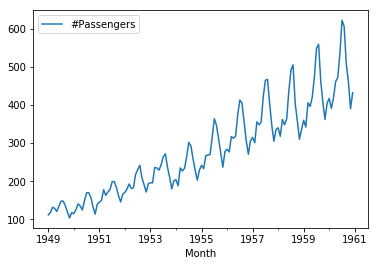

In [3]:
data.plot()

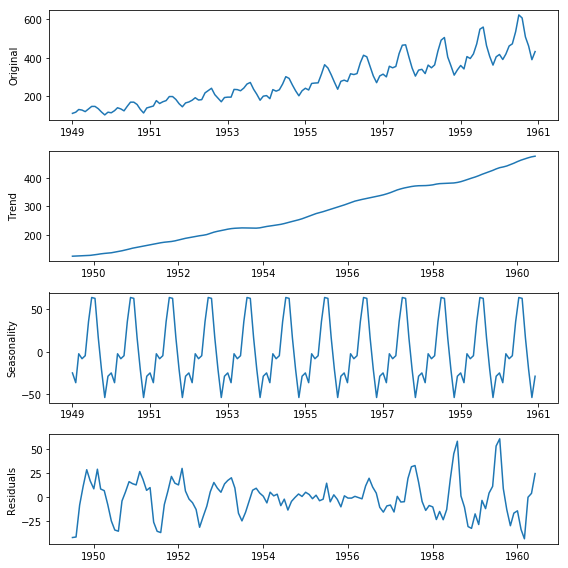

In [4]:
import statsmodels.api as sm # version 0.8.0以上
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

res = sm.tsa.seasonal_decompose(data)
original = data # オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')
# 行数, 列数, 何番目のプロットか
# trend データのプロット  トレンド
plt.subplot(412) # グラフ4行1列の2番目の位置 
plt.plot(trend)
plt.ylabel('Trend')

# seasonalデータ のプロット 季節性
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal)
plt.ylabel('Seasonality')

# residual データのプロット 残差
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

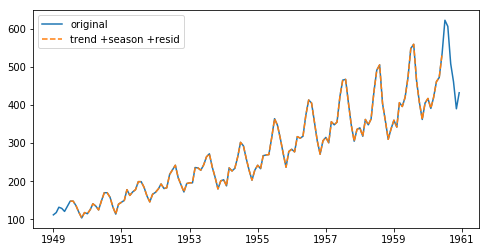

In [5]:
original = data # オリジナルデータ
trend = res.trend # トレンドデータ
seasonal = res.seasonal # 季節性データ
residual = res.resid # 残差データ
sum_three_data = trend + seasonal + residual # トレンド + 季節性 + 残差

plt.figure(figsize=(8, 4)) # グラフ描画枠作成、サイズ指定
plt.plot(original, label='original')
plt.plot(sum_three_data, label='trend +season +resid', linestyle='--')
plt.legend(loc='best') # 凡例表示

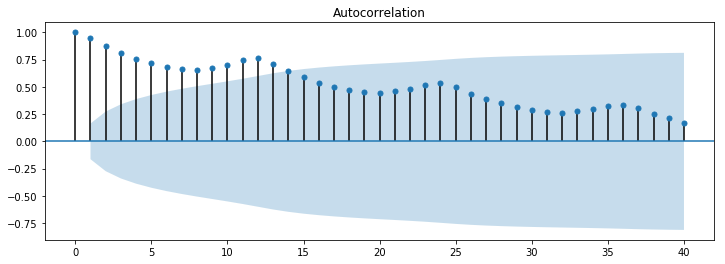

In [6]:
# 自己相関(ACF)のグラフ自動作成
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1) #飛行機乗客数データ、ラグ40、グラフaxes
plt.show() # インライン表示で同じグラフが2個出でる？ので回避

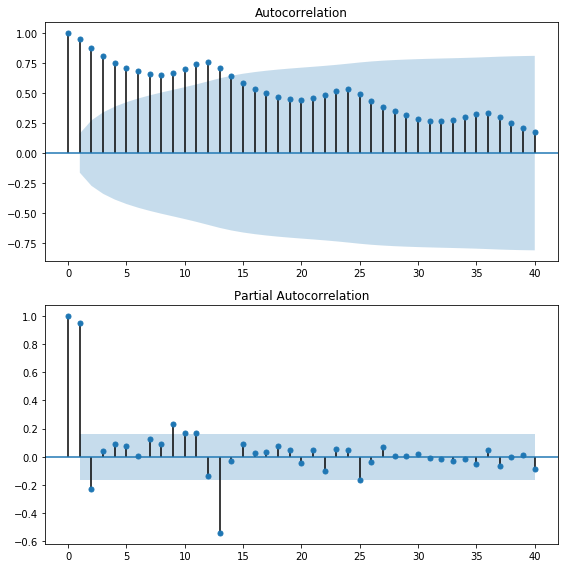

In [7]:
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2) #PACF計算とグラフ自動作成
plt.tight_layout() # グラフ間スキマ調整

In [8]:
# オリジナル passengers 1949-01 ～ 1960-12
passengers_train2 = data['1949-01':'1959-12'] # モデル作成用データ（訓練）1年テスト用残し
passengers_test2 = data['1960-01':'1960-12'] # テスト用データ1年分

# SRIMAモデル（テストデータ1年を除いてモデル作成）
sarimax_train = sm.tsa.SARIMAX(passengers_train2, 
                        order=(3, 1, 3),
                        seasonal_order=(0, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()
print(sarimax_train.summary())
sarimax_train2_pred = sarimax_train.predict('1959-12', '1960-12') # テストデータ1年分予測

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -384.674
Date:                            Sat, 15 Sep 2018   AIC                            785.347
Time:                                    15:17:10   BIC                            808.410
Sample:                                01-01-1949   HQIC                           794.719
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2221      0.122      1.813      0.070      -0.018       0.462
ar.L2         -0.3787      0.101   

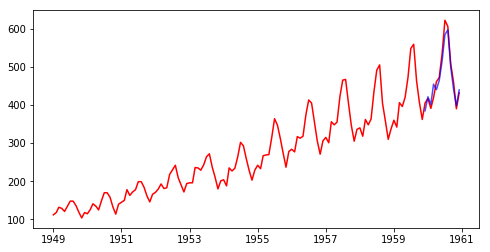

In [9]:
plt.figure(figsize=(8, 4))

plt.plot(data, c="r", label="actual")
plt.plot(sarimax_train2_pred, c="b", label="model-pred", alpha=0.7)
# plt.legend(loc='best')

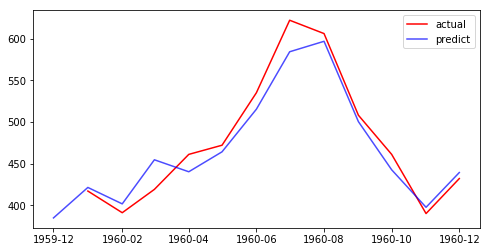

In [10]:
plt.figure(figsize=(8, 4))

plt.plot(passengers_test2, c="r", label="actual") # 正解
plt.plot(sarimax_train2_pred, c="b", label="predict", alpha=0.7) # 予測
plt.legend(loc='best')

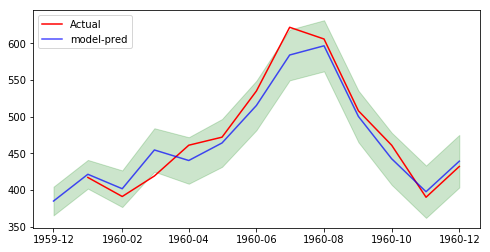

In [11]:
predict_dy = sarimax_train.get_prediction(start ='1959-12', end='1960-12')
predict_dy_ci = predict_dy.conf_int(alpha=0.05) # defalut alpah=0.05 :returns a 95% confidence interval
plt.figure(figsize=(8, 4))

plt.plot(passengers_test2, c="r",  label="Actual")
plt.plot(predict_dy.predicted_mean, c="b", label="model-pred", alpha=0.7)

plt.fill_between(predict_dy_ci.index, predict_dy_ci.iloc[:, 0], predict_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.legend(loc='upper left')

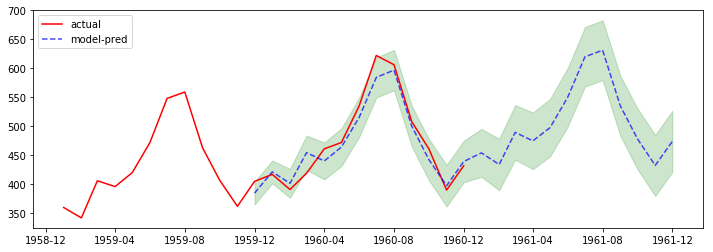

In [12]:
predict2_dy = sarimax_train.get_prediction(start ='1959-12', end='1961-12') # 2年分の未来予測

predict2_dy_ci = predict2_dy.conf_int()

plt.figure(figsize=(12, 4))
plt.plot(data['1959-01':], c="r", label="actual")
plt.plot(predict2_dy.predicted_mean, c="b", linestyle='--', label="model-pred", alpha=0.7)

plt.fill_between(predict2_dy_ci.index, predict2_dy_ci.iloc[:, 0], predict2_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.legend(loc='upper left')

In [13]:
# 実行環境
# import pkg_resources
# for dist in pkg_resources.working_set:
#     print(dist.project_name, dist.version)

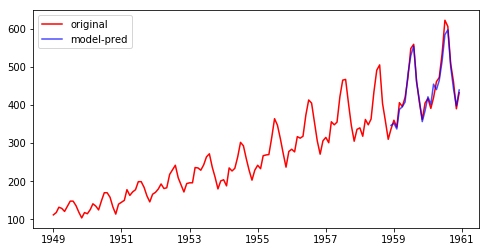

In [14]:
sarimax_train_pred = sarimax_train.predict('1958-12', '1960-12') # テストデータ2年分予測
plt.figure(figsize=(8, 4))

plt.plot(data, c="r", label="original")
plt.plot(sarimax_train_pred, c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')

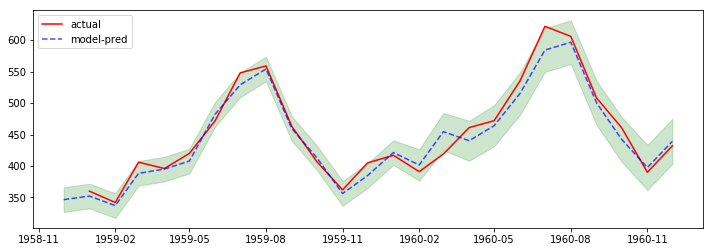

In [15]:
predict2_dy = sarimax_train.get_prediction(start ='1958-12', end='1960-12') # 2年分の未来予測

predict2_dy_ci = predict2_dy.conf_int()

plt.figure(figsize=(12, 4))
plt.plot(data['1959-01':], c="r", label="actual")
plt.plot(predict2_dy.predicted_mean, c="b", linestyle='--', label="model-pred", alpha=0.7)

plt.fill_between(predict2_dy_ci.index, predict2_dy_ci.iloc[:, 0], predict2_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.legend(loc='upper left')

In [16]:
# SARIMAパラメター最適化（総当たりチェック）
import warnings
warnings.filterwarnings('ignore') # 警告非表示（収束：ConvergenceWarning）

# パラメータ範囲
# order(p, d, q)
min_p = 1; max_p = 3 # min_pは1以上を指定しないとエラー
min_d = 0; max_d = 1
min_q = 0; max_q = 3 

# seasonal_order(sp, sd, sq)
min_sp = 0; max_sp = 1
min_sd = 0; max_sd = 1
min_sq = 0; max_sq = 1

test_pattern = (max_p - min_p +1)*(max_q - min_q + 1)*(max_d - min_d + 1)*(max_sp - min_sp + 1)*(max_sq - min_sq + 1)*(max_sd - min_sd + 1)
print("pattern:", test_pattern)

sfq = 12 # seasonal_order周期パラメータ
ts = data # 時系列データ

test_results = pd.DataFrame(index=range(test_pattern), columns=["model_parameters", "aic"])
num = 0
for p in range(min_p, max_p + 1):
    for d in range(min_d, max_d + 1):
        for q in range(min_q, max_q + 1):
            for sp in range(min_sp, max_sp + 1):
                for sd in range(min_sd, max_sd + 1):
                    for sq in range(min_sq, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts, order=(p, d, q), 
                            seasonal_order=(sp, sd, sq, sfq), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        test_results.iloc[num]["model_parameters"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), seasonal_order=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        test_results.iloc[num]["aic"] = sarima.aic
                        print(num,'/', test_pattern-1, test_results.iloc[num]["model_parameters"],  test_results.iloc[num]["aic"] )
                        num = num + 1

# 結果（最小AiC）
print("best[aic] parameter ********")
print(test_results[test_results.aic == min(test_results.aic)])

pattern: 192
0 / 191 order=(1,0,0), seasonal_order=(0,0,0) 1415.9068815931882
1 / 191 order=(1,0,0), seasonal_order=(0,0,1) 1205.3907786172608
2 / 191 order=(1,0,0), seasonal_order=(0,1,0) 1029.977309170107
3 / 191 order=(1,0,0), seasonal_order=(0,1,1) 944.3854921533092
4 / 191 order=(1,0,0), seasonal_order=(1,0,0) 1017.3155493517834
5 / 191 order=(1,0,0), seasonal_order=(1,0,1) 1007.0272556862756
6 / 191 order=(1,0,0), seasonal_order=(1,1,0) 944.0441660828052
7 / 191 order=(1,0,0), seasonal_order=(1,1,1) 945.4400866875516
8 / 191 order=(1,0,1), seasonal_order=(0,0,0) 1390.45150184149
9 / 191 order=(1,0,1), seasonal_order=(0,0,1) 1192.2949631619504
10 / 191 order=(1,0,1), seasonal_order=(0,1,0) 1014.2547824626319
11 / 191 order=(1,0,1), seasonal_order=(0,1,1) 929.4329707892156
12 / 191 order=(1,0,1), seasonal_order=(1,0,0) 1009.5891017292654
13 / 191 order=(1,0,1), seasonal_order=(1,0,1) 989.1764737572653
14 / 191 order=(1,0,1), seasonal_order=(1,1,0) 935.81633482176
15 / 191 order=(1,

126 / 191 order=(2,1,3), seasonal_order=(1,1,0) 920.9443971629127
127 / 191 order=(2,1,3), seasonal_order=(1,1,1) 906.0326961886267
128 / 191 order=(3,0,0), seasonal_order=(0,0,0) 1380.745870393287
129 / 191 order=(3,0,0), seasonal_order=(0,0,1) 1201.6257665305397
130 / 191 order=(3,0,0), seasonal_order=(0,1,0) 1008.7465064755736
131 / 191 order=(3,0,0), seasonal_order=(0,1,1) 937.5672738392866
132 / 191 order=(3,0,0), seasonal_order=(1,0,0) 996.6216552992037
133 / 191 order=(3,0,0), seasonal_order=(1,0,1) 983.9064043818265
134 / 191 order=(3,0,0), seasonal_order=(1,1,0) 922.4280801274903
135 / 191 order=(3,0,0), seasonal_order=(1,1,1) 928.978943942019
136 / 191 order=(3,0,1), seasonal_order=(0,0,0) 1381.0403561243675
137 / 191 order=(3,0,1), seasonal_order=(0,0,1) 1166.6356306181324
138 / 191 order=(3,0,1), seasonal_order=(0,1,0) 1010.7204332699082
139 / 191 order=(3,0,1), seasonal_order=(0,1,1) 932.6552398279293
140 / 191 order=(3,0,1), seasonal_order=(1,0,0) 998.6206019016744
141 / 

In [17]:
test_results.sort_values(by='aic').head(10) # aic top10

,model_parameters,aic
187,"order=(3,1,3), seasonal_order=(0,1,1)",898.105
59,"order=(1,1,3), seasonal_order=(0,1,1)",902.483
191,"order=(3,1,3), seasonal_order=(1,1,1)",903.239
63,"order=(1,1,3), seasonal_order=(1,1,1)",903.795
123,"order=(2,1,3), seasonal_order=(0,1,1)",905.946
127,"order=(2,1,3), seasonal_order=(1,1,1)",906.033
190,"order=(3,1,3), seasonal_order=(1,1,0)",910.008
174,"order=(3,1,1), seasonal_order=(1,1,0)",911.376
115,"order=(2,1,2), seasonal_order=(0,1,1)",911.698
91,"order=(2,0,3), seasonal_order=(0,1,1)",911.832


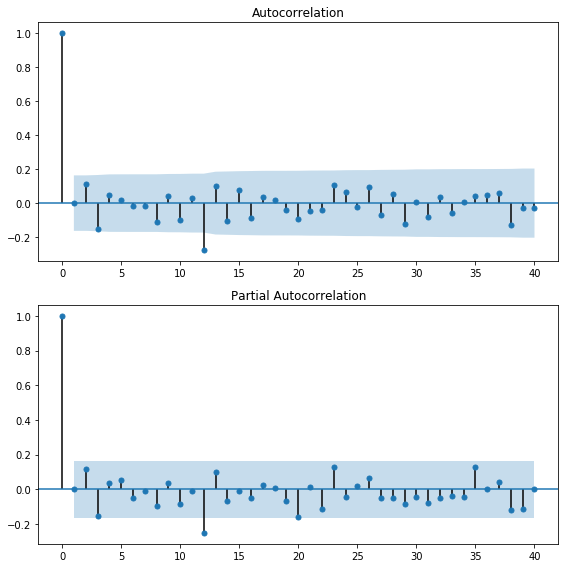

In [18]:
# SRIMAモデル（ちょっとだけパラメータ最適化・総当たりaicベストを適用）
sarimax_optimization = sm.tsa.SARIMAX(data, 
                        order=(3, 1, 3),
                        seasonal_order=(0, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_optimization_resid = sarimax_optimization.resid # 残差成分

fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_optimization_resid, lags=40, ax=ax1) 

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_optimization_resid, lags=40, ax=ax2)

plt.tight_layout() # グラフ間スキマ調整

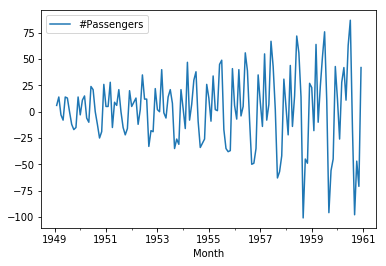

In [19]:
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示
passengers_diff = data - data.shift() # 差分(1階差)　Pandasのdiff()でpassengers.diff()としてもOK
passengers_diff = passengers_diff.dropna() # 1個できるNaNデータは捨てる
passengers_diff.plot()

In [20]:
# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(passengers_diff, ic='aic', trend='nc')
res_selection

{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175687
 3  1395.021214  1379.614000  1351.138688
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}